In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gdal
from os import listdir, mkdir
from os.path import isfile, join, getsize, expanduser, basename, isdir
gdal.SetCacheMax(2**35)


## Checking the values and plotting the Tif files

In [2]:
CROP_SENTINEL = 12  # if the pixel has value 12 means there is 60% of cultivated territory 
                    # which is the type of territoy we are interested in
NUM_TEMP_BANDS = 2
NUM_IMGS_PER_YEAR = 45
NUM_REF_BANDS = 7


In [3]:
def return_tif_filenames(path):
    return [f for f in listdir(path) if (isfile(join(path, f)) and not f.startswith('.') and f.endswith('.tif'))]


def collect_tif_path_dict(temp_dir, mask_dir, verbose=True):
    """
    Returns a dictionary of form {name of place : (temp path, mask path)}
    """
    all_temp_files = return_tif_filenames(temp_dir)
    temp_places = get_places(all_temp_files)
    all_mask_files = return_tif_filenames(mask_dir)
    mask_places = get_places(all_mask_files)
    tif_dict = {}

    for t_i, place in enumerate(temp_places):
        if place not in mask_places:
            if verbose:
                print(place, ' missing mask file')
            continue
        m_i = mask_places.index(place)
        tif_dict[place] = (all_temp_files[t_i], all_mask_files[m_i])
    return tif_dict


def read_tif(tif_path):
    """
    Reads tif image into a tensor
    """
    try:
        gdal_dataset = gdal.Open(tif_path)
    except:
        print('Error opening', tif_path, 'with gdal')
        return None

    if gdal_dataset is None:
        print('gdal returned Non from: ', tif_path)
        return None

    gdal_result = gdal_dataset.ReadAsArray().astype(np.uint16)

    # If a tif file has only 1 band, then the band dimension will be removed.
    if len(gdal_result.shape) == 2:
        gdal_result = np.reshape(gdal_result, [1] + list(gdal_result.shape))

    # gdal_result is a rank 3 tensor as follows (bands, height, width). Transpose.
    return np.transpose(gdal_result, [1, 2, 0])


def get_places(filenames):
    """
    Gets places of tif imagery from filenames in list. Assumes names are of form
    <country>_<img type>_<place name>.tif|_<date info>.tif
    """
    places = []
    for f in filenames:
        place = f.split('_')[2]
        if place.find('tif') != -1:
            place = place[:-1]
        places.append(place)
    return places


def mask_image(img, mask, num_bands):
    """
     Masks away non-crop pixels in all 2D slices of 3D image tensor of shape X x Y x (bands/time)
    """
    num_imgs = img.shape[2]/num_bands
    assert num_imgs == int(num_imgs)
    num_imgs = int(num_imgs)
    remainder_imgs = num_imgs % NUM_IMGS_PER_YEAR

    for t in range(num_imgs):
        if t-remainder_imgs < 0:  # masking all temp images of 2010
            mask_slice = mask[:, :, 0]
        else:  # masking all remaining temp images
            mask_year = int((t-remainder_imgs)/NUM_IMGS_PER_YEAR)
            mask_slice = mask[:, :, mask_year+1]
        for b in range(num_bands):
            img[:, :, t*num_bands +
                b] = np.multiply(img[:, :, t*num_bands + b], mask_slice)
    return img


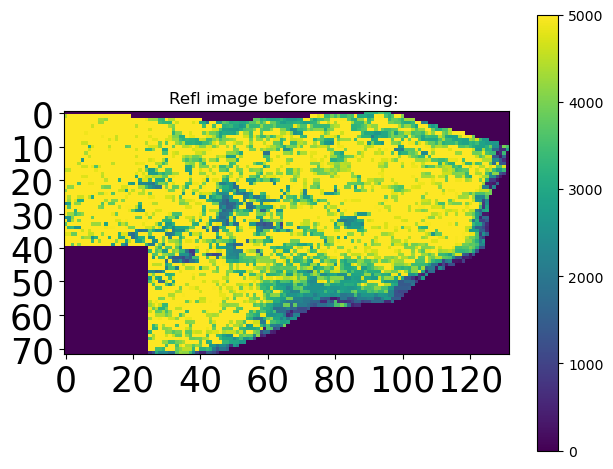

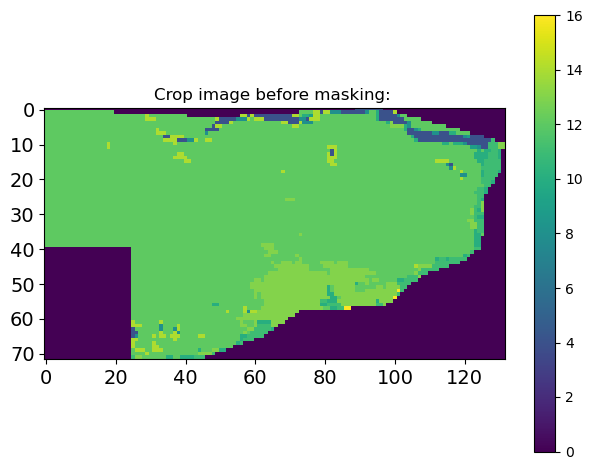

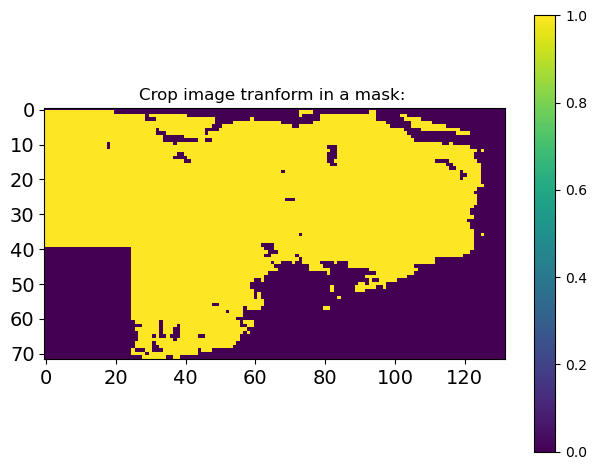

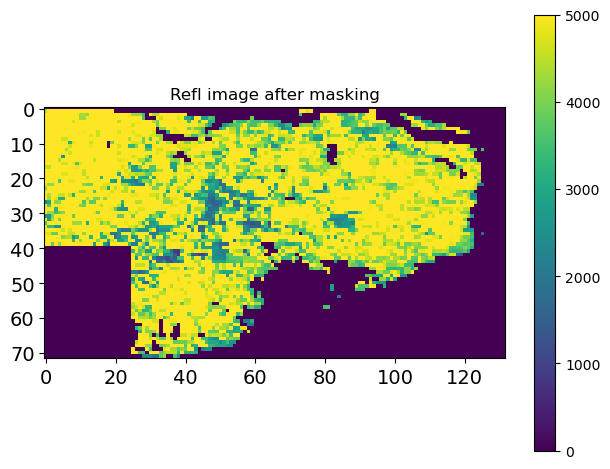

In [10]:

tensor_refl = read_tif('sat/usa_sat_scott-ia_2010-02-24_2016-12-31.tif')
test_tensor_mask = read_tif('mask/usa_cover_scott-ia_2010-01-01_2016-12-31.tif')

df_day = pd.DataFrame(tensor_refl[:,:,0])
df_day.describe()
df_night = pd.DataFrame(tensor_refl[:,:,1])
df_night.describe()

plt.imshow(tensor_refl[:, :, 1])
plt.title('Refl image before masking: ')
plt.colorbar()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Refl image before masking', dpi=500)
plt.tight_layout()
plt.show()

plt.imshow(test_tensor_mask[:, :, 0])
plt.title('Crop image before masking: ')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Original crop image:', dpi=500)
plt.tight_layout()
plt.show()

test_tensor_mask[test_tensor_mask != CROP_SENTINEL] = 0
test_tensor_mask[test_tensor_mask == CROP_SENTINEL] = 1
tensor_refl = mask_image(tensor_refl, test_tensor_mask, NUM_REF_BANDS)

plt.imshow(test_tensor_mask[:, :, 0])
plt.title('Crop image tranform in a mask: ')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Crop image after masking', dpi=500)
plt.tight_layout()
plt.show()

plt.imshow(tensor_refl[:, :, 1])
plt.title('Refl image after masking')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('refl image after masking ', dpi=500)
plt.tight_layout()
plt.show()